In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd
import nltk
import sys
import os

In [33]:
custom_dict = pd.read_csv("./dictionary/custom_dictionary.csv")

df = pd.read_csv("./data/clean_dataset.csv")

In [34]:
# Separar palabras por polaridad en sets para búsqueda rápida
positive_words = set(custom_dict[custom_dict['polarity'] == 'positive']['word'])
negative_words = set(custom_dict[custom_dict['polarity'] == 'negative']['word'])
neutral_words = set(custom_dict[custom_dict['polarity'] == 'neutral']['word'])


In [35]:
def count_sentiment_words(text):
    if pd.isna(text):
        return 0,0,0
    
    tokens = word_tokenize(text)
    pos_count = sum(1 for w in tokens if w in positive_words)
    neg_count = sum(1 for w in tokens if w in negative_words)
    neu_count = sum(1 for w in tokens if w in neutral_words)

    return pos_count, neg_count, neu_count

df[['pos_count', 'neg_count', 'neu_count']] = df['review_translated_text'].apply(
    lambda x: pd.Series(count_sentiment_words(x))
    )

In [36]:
X = df[['pos_count', 'neg_count', 'neu_count']]

y = df["rating_bin"]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [39]:
y_pred = clf.predict(X_test)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

Accuracy: 0.8010 (80.10%)

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.78      0.54      0.64      9202
    Positivo       0.81      0.93      0.86     18865

    accuracy                           0.80     28067
   macro avg       0.79      0.73      0.75     28067
weighted avg       0.80      0.80      0.79     28067



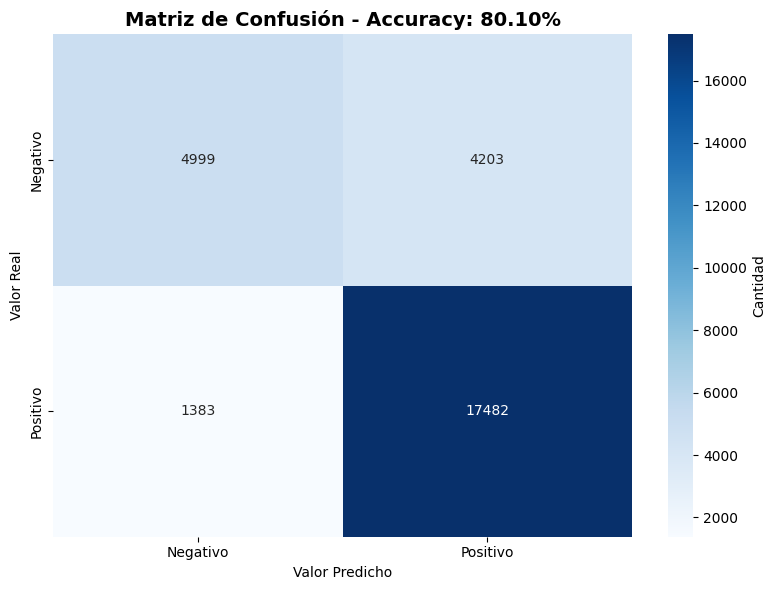

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'],
            cbar_kws={'label': 'Cantidad'})
plt.title(f'Matriz de Confusión - Accuracy: {accuracy:.2%}', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.tight_layout()
plt.show()

plt.savefig('results/ml_confusion_matrix.png')


In [ ]:

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]



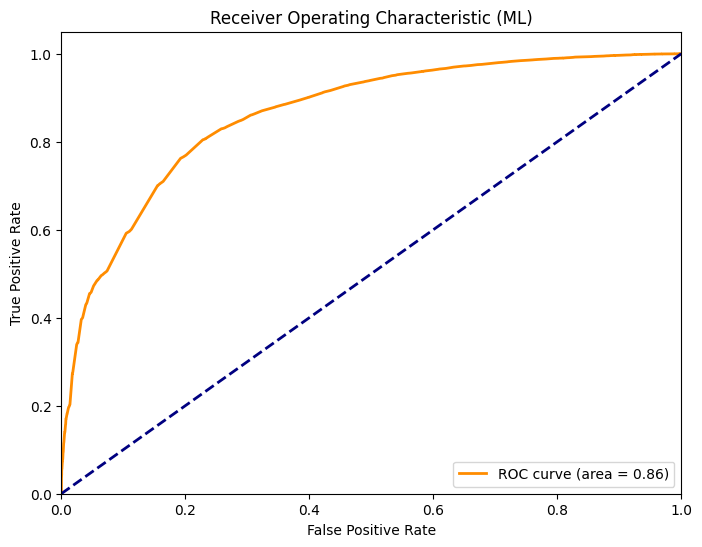

In [47]:

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ML)')
plt.legend(loc="lower right")
plt.savefig('results/ml_roc_curve.png')
plt.show()



In [44]:
# Guardar modelo entrenado
with open('./models/sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

print("✓ Modelo guardado en: ./models/sentiment_classifier.pkl")

✓ Modelo guardado en: ./models/sentiment_classifier.pkl


In [ ]:
def predict_sentiment(text):
    """Predice el sentimiento de una nueva reseña."""
    pos, neg, neu = count_sentiment_words(text)
    
    features = pd.DataFrame([[pos, neg, neu]], columns=['pos_count', 'neg_count', 'neu_count'])
    prediction = clf.predict(features)[0]
    proba = clf.predict_proba(features)[0]
    
    print(f"Texto: {text}")
    print(f"\nPalabras detectadas:")
    print(f"  Positivas: {pos}")
    print(f"  Negativas: {neg}")
    print(f"  Neutras: {neu}")
    print(f"\nPredicción: {'POSITIVO' if prediction == 1 else 'NEGATIVO'}")
    print(f"Confianza: {max(proba):.2%}")
    
    return prediction

# Probar con ejemplos
ejemplos = [
    "The food was excellent and the service was great!",
    "Terrible experience, cold food and rude staff.",
    "Horrible food but beatiful views"

]

for ejemplo in ejemplos:
    print("=" * 70)
    predict_sentiment(ejemplo)
    print()